В ноутбуке происходт обработка оригинальных статей - избавление от артефактов парсинга и веб страницы, удаление блоков, не относящихся к статье (реклама, призывы к действию), очистка страницы от тегов и лишних пробелов, переноса строк

* 0. Инициализация
* 1. Обработка оригинальных статей издания The Guardian
* 2. Обработка оригинальных статей new York Times
* 3. Анализ новостей


In [1]:
from utils_create_news import try_load, save_s3, clean_article_text, remove_tags_bs
from dotenv import load_dotenv
from minio import Minio

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import os
import re

/Users/dan/.matplotlib is not a writable directory
Matplotlib created a temporary cache directory at /var/folders/6p/bshr1_dj3_7_gk1krflr4lzm0000gn/T/matplotlib-mkmjj1at because there was an issue with the default path (/Users/dan/.matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


# 0. Инициализация

In [2]:
load_dotenv()

YANDEX_CLOUD_ACCESS_KEY = os.getenv("AWS_ACCESS_KEY_ID_2")
YANDEX_CLOUD_SECRET_KEY = os.getenv("AWS_SECRET_ACCESS_KEY_2")
DEEPSEEK_API_KEY_2 = os.getenv("DEEPSEEK_API_KEY_2")

BUCKET_NAME = 'graduate' # s3

PATH = '/Users/dan/git_repo/graduate/'

In [3]:
client_s3 = Minio(
    "storage.yandexcloud.net",
    access_key=YANDEX_CLOUD_ACCESS_KEY,
    secret_key=YANDEX_CLOUD_SECRET_KEY,
    secure=True
)

In [ ]:
# Спаршенные новости
the_guardian_politic_news_09022025 = try_load(file_path=PATH+'data/', file_name='the_guardian_politic_news_09022025.pkl', client_s3=client_s3)

# 1. Обработка оригинальных статей издания The Guardian

Артефакты

**Статья 67**

Удалить секции типа "Listen to this", "Read more", "What’s on the grid" и подобные.
Вставка "Quote of the day", "Read more", "Listen to this" — это типичные форматные вставки новостных сайтов, а именно Guardian.


**Статья 2002**

"John Crace’s book Depraved New World (Guardian Faber, £16.99) is out now. To support the Guardian and Observer, order your copy and save 18% at guardianbookshop.com . Delivery charges may apply"
→ Это реклама книги и призыв подписаться — явный след издания (The Guardian).

**Статья 2003**

"Updated at 10.02am GMT"
→ Метка времени, которая встречается в онлайн-статьях.


**Статья 2004**

"• This article was amended on 11 June 2024 to rephrase reference to US authorities having previously pursued Calvin Ayre."
→ Примечание редакции — встречается только в реальных новостях.

**Статья 3000**

"• This article was amended on 28 July 2023. A previous version said the Conservatives had a majority of 36,000... corrected to just over 21,000."
→ Редакционная правка — явный артефакт новостного сайта.

**Статья 3001**

Updated at 10.16am BST 
→ Метка времени (10.16am BST) — технический элемент CMS.

**Промпт**

1) причем без корректной чистки от служебной информации сайта.

2) В оригинальных статьях часто присутсвует приписка "guardian"

___Пример статьи до обработки___

In [537]:
# Возьмем 1 статью для разбора
the_guardian_politic_news_09022025_keys = list(the_guardian_politic_news_09022025.keys())
tg_key = np.random.choice(the_guardian_politic_news_09022025_keys)

tg_key = the_guardian_politic_news_09022025_keys[3000]

example = the_guardian_politic_news_09022025[tg_key][1]
example = example.replace('</p>', '</p>\n')
print(example)

<p>Rishi Sunak is under pressure from Conservative MPs to “kick off” a controversial rightwing politician from the party’s approved candidates’ list after his grassroots organisation campaigned to deselect Tory MPs and attacked the integrity of the privileges committee inquiry into Boris Johnson.</p>
 <p>David Campbell Bannerman, a former deputy leader of the UK Independence party (Ukip) who defected back to the Tories in 2011, has said he wants to stand for the safe South Norfolk constituency, where the party had a majority of just over 21,000 at the last general election.</p>
 <p>The former MEP launched the Conservative Democratic Organisation last year, alongside the Tory peer and Johnson loyalist Peter Cruddas, to campaign for members’ rights, although the rightwing group also lobbied to have Johnson reinstated as prime minister.</p>
 <p>The CDO was criticised by the Commons privileges committee after it orchestrated a mass email campaign through its online magazine, to put pressur

___Избавимся от тегов___

In [538]:
# Пример
example_v2 = remove_tags_bs(example)
print(example_v2)

Rishi Sunak is under pressure from Conservative MPs to “kick off” a controversial rightwing politician from the party’s approved candidates’ list after his grassroots organisation campaigned to deselect Tory MPs and attacked the integrity of the privileges committee inquiry into Boris Johnson.
David Campbell Bannerman, a former deputy leader of the UK Independence party (Ukip) who defected back to the Tories in 2011, has said he wants to stand for the safe South Norfolk constituency, where the party had a majority of just over 21,000 at the last general election.
The former MEP launched the Conservative Democratic Organisation last year, alongside the Tory peer and Johnson loyalist Peter Cruddas, to campaign for members’ rights, although the rightwing group also lobbied to have Johnson reinstated as prime minister.
The CDO was criticised by the Commons privileges committee after it orchestrated a mass email campaign through its online magazine, to put pressure on the Tory members to st

___Обработаем регуляркой___

In [539]:
# Пример
example_v3 = clean_article_text(example_v2)
print(example_v3)

Rishi Sunak is under pressure from Conservative MPs to “kick off” a controversial rightwing politician from the party’s approved candidates’ list after his grassroots organisation campaigned to deselect Tory MPs and attacked the integrity of the privileges committee inquiry into Boris Johnson.
David Campbell Bannerman, a former deputy leader of the UK Independence party (Ukip) who defected back to the Tories in 2011, has said he wants to stand for the safe South Norfolk constituency, where the party had a majority of just over 21,000 at the last general election.
The former MEP launched the Conservative Democratic Organisation last year, alongside the Tory peer and Johnson loyalist Peter Cruddas, to campaign for members’ rights, although the rightwing group also lobbied to have Johnson reinstated as prime minister.
The CDO was criticised by the Commons privileges committee after it orchestrated a mass email campaign through its online magazine, to put pressure on the Tory members to st

___Подготовим весь текст___

In [542]:
the_guardian_clean_politic_news_03052025 = dict()

for key in the_guardian_politic_news_09022025_keys:
    titile = the_guardian_politic_news_09022025[key][0]
    paper = the_guardian_politic_news_09022025[key][1]
    paper = paper.replace('</p>', '</p>\n') # Каждый абзац с новой строки 
    paper = remove_tags_bs(paper) # Избавимся от тегов
    paper = clean_article_text(paper) # обработаем регуляркой

    the_guardian_clean_politic_news_03052025[key] = [titile, paper]

In [543]:
save_s3(pickle_data=the_guardian_clean_politic_news_03052025, object_key='the_guardian_clean_politic_news_03052025.pkl', client_s3=client_s3)

with open(PATH+'/data/the_guardian_clean_politic_news_03052025.pkl', 'wb') as file: 
    pickle.dump(the_guardian_clean_politic_news_03052025, file)

# 2. Обработка оригинальных статей new York Times

In [4]:
papers_nyt = try_load(file_path=PATH+'data/', file_name='papers_nyt.pkl', client_s3=client_s3)
papers_nyt_keys = list(papers_nyt.keys())

___Удалим артефакты парсинга___

In [5]:
# Примеры м артефактами "Credit..." и "Reporting from"
for i, key in enumerate(papers_nyt_keys[60:70]):
    text = papers_nyt[key]
    print(f'Статя {i}: ', text)

Статя 0:  Newsletter His executive order curbing asylum aligned him with a broad swath of the public in an election year. President Biden’s decision this week to seal the border temporarily to most asylum seekers was a striking policy shift. It sharply divided his party, invited comparisons to policies backed by former President Donald Trump and made him the owner of the most restrictive immigration measure ever to be carried out by a modern Democratic president. It also aligned him with a broad swath of the public on a key issue in an election year. A confluence of hyperbolic rhetoric from Republicans, led by Trump, and a surge in illegal border crossings in recent years has pushed immigration and border security to the forefront of the nation’s election-year psyche, turning immigration into a top concern for voters on both sides of the partisan divide — and a major liability for the president. Biden’s executive order, which took effect at 12:01 a.m. on Wednesday, is expected to be th

In [6]:
# Примеры работы регулярок
for i, key in enumerate(papers_nyt_keys[60:70]):
    text = papers_nyt[key]
    cleaned_text = re.sub(r'[^.!?]*\bReporting from\b[^.!?]*[.!?]', '',  text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r'\s*Credit\s*\.{3}\s*', ' ', cleaned_text)

    print(f'Статя {i}: ', cleaned_text)

Статя 0:  Newsletter His executive order curbing asylum aligned him with a broad swath of the public in an election year. President Biden’s decision this week to seal the border temporarily to most asylum seekers was a striking policy shift. It sharply divided his party, invited comparisons to policies backed by former President Donald Trump and made him the owner of the most restrictive immigration measure ever to be carried out by a modern Democratic president. It also aligned him with a broad swath of the public on a key issue in an election year. A confluence of hyperbolic rhetoric from Republicans, led by Trump, and a surge in illegal border crossings in recent years has pushed immigration and border security to the forefront of the nation’s election-year psyche, turning immigration into a top concern for voters on both sides of the partisan divide — and a major liability for the president. Biden’s executive order, which took effect at 12:01 a.m. on Wednesday, is expected to be th

In [7]:
# Очистка текста
for key in papers_nyt_keys:
    text = papers_nyt[key]

    cleaned_text = re.sub(r'[^.!?]*\bReporting from\b[^.!?]*[.!?]', '',  text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r'\s*Credit\s*\.{3}\s*', ' ', cleaned_text)
    cleaned_text = re.sub(r'[^.!?]*contributed reporting[^.!?]*[.!?]', '', text)

    papers_nyt[key] = cleaned_text

___Удалим короткие статьи___

In [8]:
# Статьи короче 100 слов
papers_nyt_keys = list(papers_nyt.keys())
short_papers = list()

for key in papers_nyt_keys:
    if len(papers_nyt[key].split()) < 100:
        short_papers.append(key)

for key in short_papers:
    del papers_nyt[key]

papers_nyt_keys = list(papers_nyt.keys())

print(len(papers_nyt_keys))

2242


In [9]:
save_s3(pickle_data=papers_nyt, object_key='papers_nyt_clean.pkl', client_s3=client_s3)

with open(PATH+'/data/papers_nyt_clean.pkl', 'wb') as file: 
    pickle.dump(papers_nyt, file)

# 3. Анализ новостей

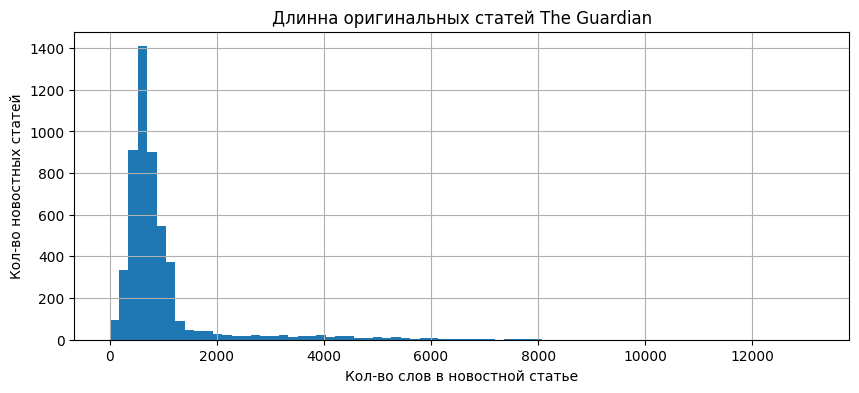

The guardian paper
Среднее: 964.13
Медиана: 684.00
Квантиль 0.05: 276.95
Квантиль 0.95: 3187.05


In [26]:
# Соберем длинну новостных статей The Guardian
cnt_len_memmory_tg = []
for paper in the_guardian_clean_politic_news_03052025.values():
    paper = paper[1]
    cnt_len_memmory_tg.append(
        len(paper.split(' '))
    )

cnt_len_memmory_tg = pd.Series(cnt_len_memmory_tg)

# График
plt.figure(figsize=(10,4))
cnt_len_memmory_tg.hist(bins=75)

plt.title('Длинна оригинальных статей The Guardian')
plt.xlabel('Кол-во слов в новостной статье')
plt.ylabel('Кол-во новостных статей')
plt.show()

# Выведем статистику по статьям
tg_mean, tg_median, tg_q05, tg_q95 = cnt_len_memmory_tg.mean(), cnt_len_memmory_tg.median(), cnt_len_memmory_tg.quantile(0.05), cnt_len_memmory_tg.quantile(0.95)
print('The guardian paper')
print(f'Среднее: {tg_mean:.2f}\nМедиана: {tg_median:.2f}\nКвантиль 0.05: {tg_q05:.2f}\nКвантиль 0.95: {tg_q95:.2f}')

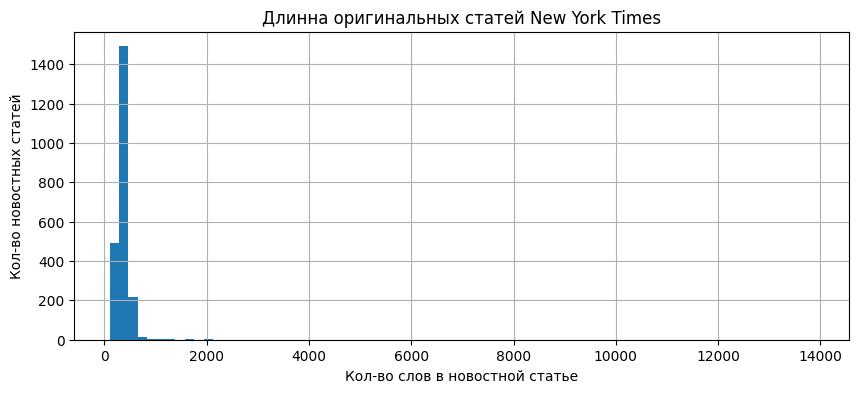

New York Times
Среднее: 381.31
Медиана: 333.00
Квантиль 0.05: 241.00
Квантиль 0.95: 529.95


In [10]:
# Соберем длинну новостных статей New York Times
cnt_len_memmory_nyt = []
for paper in papers_nyt.values():
    cnt_len_memmory_nyt.append(
        len(paper.split(' '))
    )

cnt_len_memmory_nyt = pd.Series(cnt_len_memmory_nyt)

# График
plt.figure(figsize=(10,4))
cnt_len_memmory_nyt.hist(bins=75)

plt.title('Длинна оригинальных статей New York Times')
plt.xlabel('Кол-во слов в новостной статье')
plt.ylabel('Кол-во новостных статей')
plt.show()

# Выведем статистику по статьям
nyt_mean, nyt_median, nyt_q05, nyt_q95 = cnt_len_memmory_nyt.mean(), cnt_len_memmory_nyt.median(), cnt_len_memmory_nyt.quantile(0.05), cnt_len_memmory_nyt.quantile(0.95)
print('New York Times')
print(f'Среднее: {nyt_mean:.2f}\nМедиана: {nyt_median:.2f}\nКвантиль 0.05: {nyt_q05:.2f}\nКвантиль 0.95: {nyt_q95:.2f}')

In [34]:
# Заголовки и статьи The Guardian
the_guardian_clean_politic_news_keys = list(the_guardian_clean_politic_news_03052025.keys())

for _ in range(10):
    key = np.random.choice(the_guardian_clean_politic_news_keys)
    print(the_guardian_clean_politic_news_03052025[key])
    print(' ')

['Conservatives fighting to stem loss of high-value donors to Reform UK', 'The Conservatives are fighting back in an attempt to stem the loss of high-value donors amid a shift in funders towards Nigel Farage’s Reform UK party.\nThe party’s leader, Kemi Badenoch, is expected to appear at the Conservatives’ London conference in Westminster on Saturday, where wealthy party donors say they have been invited to evening drinks.\nIt comes after Reform’s fundraiser in Mayfair on Tuesday which was attended by former Conservative donors including Bassim Haidar and Mohamed Amersi, who each paid £25,000 to join a top table with Farage.\nSources in Reform say that pledges of more than £1m had already come in from businesspeople, and the Guardian understands there is now deep concern at Conservative central headquarters (CCHQ) that many of their donors are considering switching to Farage’s party.\nOne Conservative source said the past few months appeared to be one of the worst periods ever for the p

In [11]:
# Заголовки и статьи The Guardian и New york Times
papers_nyt_keys = list(papers_nyt.keys())

for _ in range(10):
    key = np.random.choice(papers_nyt_keys)
    print(key, "|||",  papers_nyt[key])
    print(' ')

Harris Campaign Looks Poised to Beat Trump’s July Cash Haul ||| The Trump campaign reported raising $139 million along with allied groups. The vice president’s campaign previously reported $200 million raised in the seven days after President Biden dropped out. The Trump campaign said that it and its allied groups had raised $139 million in July, an enormous sum — but well short of the $200 million Vice President Kamala Harris’s campaign said it brought in amid a huge burst of enthusiasm about her candidacy. The sum cited by the Trump campaign on Thursday sent it and its allies into August with $327 million in their bank accounts. It makes July one of the Trump team’s strongest fund-raising months to date, just off the sum raised in May, when Mr. Trump’s supporters responded to his felony conviction with an outpouring of donations totaling $141 million. After collecting $112 million in June, the Trump team saw donations tick up in July as Mr. Trump survived an assassination attempt, wa